In [42]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

In [43]:
data = pd.read_csv("data/WaffleDivorce.csv",sep=';', header=0)

In [ ]:
data

<h1>Divorce Rate </h1>
Assume we are interested the factors that determine the  divorece rates and all the data we have is the one above.


Text(0.5, 0, 'Median age marriage')

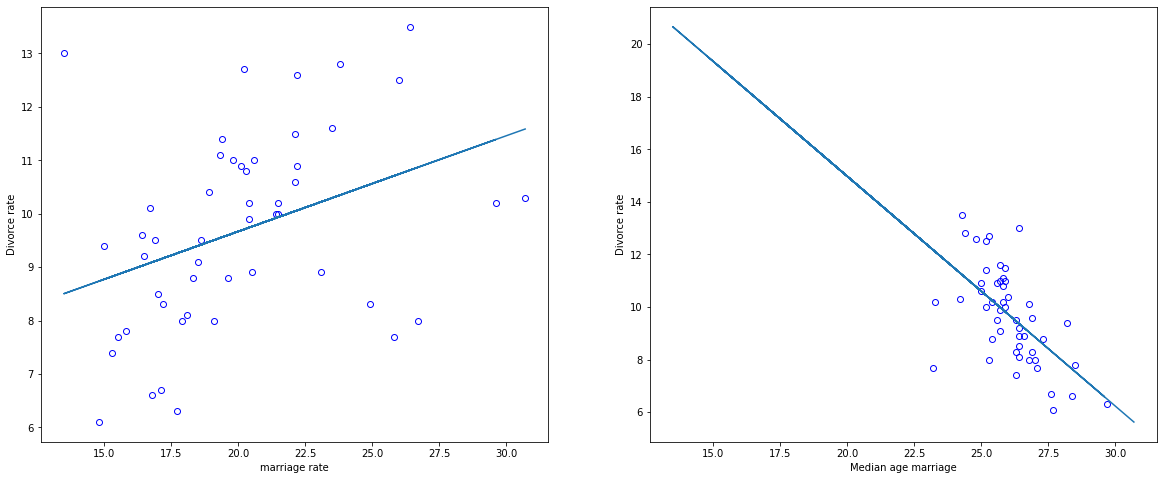

In [44]:
m1, b1 = np.polyfit( data["Marriage"], data["Divorce"], 1)
m2,b2=np.polyfit( data["MedianAgeMarriage"], data["Divorce"], 1)
fid, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].scatter(
    data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b"
)
ax[0].plot( data["Marriage"], m1* data["Marriage"] + b1)
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("marriage rate")
#ax[0].plot( data["Marriage"], data["Marriage"].mean() + data["Divorce"].mean() *data["Marriage"])
ax[1].scatter(
    data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b"
)
ax[1].plot( data["Marriage"], m2* data["Marriage"] + b2)
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")


<p>But does marriage cause divorce? In a trivial sense it obviously does: One cannot
get a divorce without first getting married. But there’s no reason high marriage rate must
be correlated with divorce. It’s easy to imagine high marriage rate indicating high cultural
valuation of marriage and therefore being associated with low divorce rate. So something is
suspicious here.</p><p>
Another predictor associated with divorce is the median age at marriage, displayed in
the right-hand plot iabove. Age at marriage is also a good predictor of divorce rate—
higher age at marriage predicts less divorce. Let’s load these data and standardize the variables
of interest:</p>

In [45]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

 Now lets try a regression on the median marriage age. First our model:

Di ∼ Normal(μ <sub>i </sub>, σ)

μ<sub>i</sub> = α + β<sub>A</sub>A<sub>i</sub>

α ∼ Normal(0, 0.2)


β<sub>A</sub> ∼ Normal(0, 0.5)


σ ∼ Exponential(1)

<p>
    where  <b>D<sub>i</sub> is the standardized </b>(zero centered, standard deviation one) divorce rate for State i, and
    A<sub>i</sub> is State i’s standardized median age at marriage.</p>
    
    
What about those priors? Since the outcome (Divorce rate) and the predictor  (median age) are both standardized, the
intercept α should end up very close to zero. 

What does the prior slope β<sub>A</sub> imply? If β<sub>A</sub> = 1,
that would imply that a change of one standard deviation in age at marriage is associated
likewise with a change of one standard deviation in divorce. To know whether or not that is
a strong relationship, you need to know how big a standard deviation of age at marriage is:

 
 

In [10]:
data["MedianAgeMarriage"].std()

1.2436303013880823

So when βA = 1, a change of 1.2 years in median age at marriage is associated with a full
standard deviation change in the outcome variable. That seems like an insanely strong relationship.
The prior above thinks that only 5% of plausible slopes more extreme than 1. We’ll
simulate from these priors in a moment, so you can see how they look in the outcome space.

In [46]:
with pm.Model() as medianagevsdivorce:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_mediangevsdivorce = pm.sample_prior_predictive()
    
    mediangevsd_tarce = pm.sample()
    posteriorpredictive_medianagevsdicvorce=pm.sample_posterior_predictive(mediangevsd_tarce)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
100%|██████████| 1000/1000 [00:02<00:00, 338.61it/s]


In [12]:
 prior_mediangevsdivorce.keys()

dict_keys(['sigma_log__', 'a', 'mu', 'sigma', 'bA', 'divorce_rate_std'])

In [13]:
%matplotlib inline 

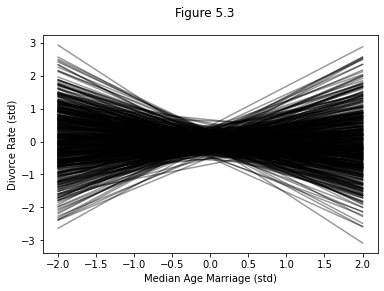

In [47]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_mediangevsdivorce ["a"][:], prior_mediangevsdivorce ["bA"][:]):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");



Plausible regression lines implied
by the priors in m5.1. These are weakly informative
priors in that they allow some implusibly
strong relationships but generally bound
the lines to possible ranges of the variables.

Posterior distributions

mediangevsd_tarce = pm.sample()
    posteriorpredictive_medianagevsdicvorce=pm.sample_posterior_predictive(mediangevsd_tarce)

In [ ]:
  posteriorpredictive_medianagevsdicvorce

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


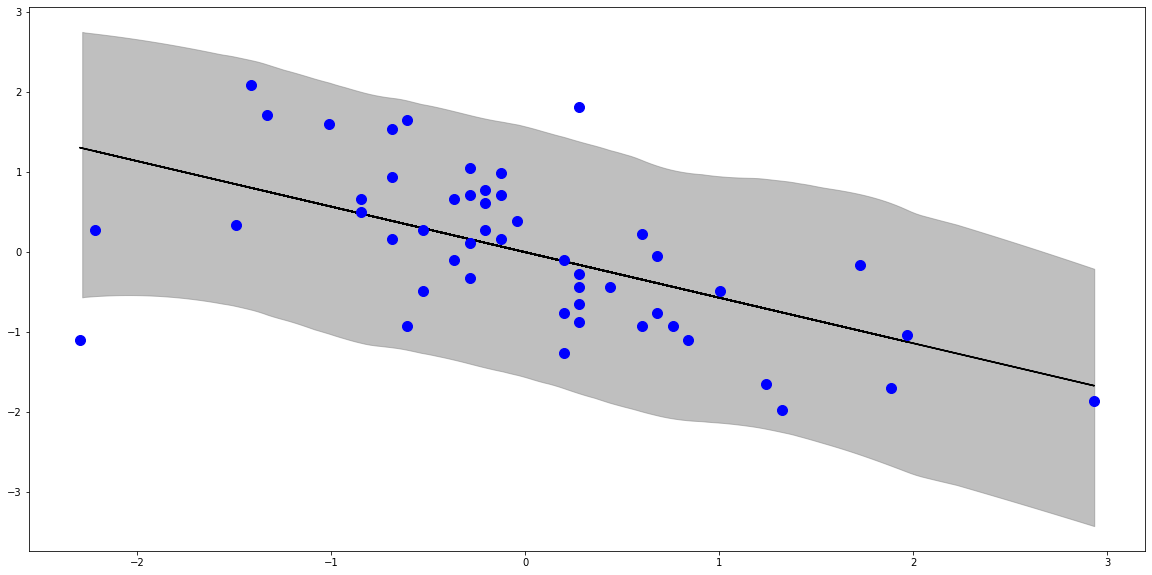

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
az.plot_hdi(data["MedianAgeMarriage_std"],   posteriorpredictive_medianagevsdicvorce["divorce_rate_std"], credible_interval=0.94, color='gray', ax=ax)
plt.plot(data["MedianAgeMarriage_std"],  mediangevsd_tarce["a"].mean() +  mediangevsd_tarce["bA"].mean() * (data["MedianAgeMarriage_std"]),color="black")
plt.plot(data["MedianAgeMarriage_std"],data["Divorce_std"], 'b.', markersize=20)
#plt.plot(df2.weight, tracedeterminist["alpha"].mean() + tracedeterminist["beta"].mean() * (df2.weight_c),color="black")
#plt.plot(df2.weight, df2.height, 'b.', markersize=20)

In [57]:
mediangevsd_tarce["bA"].mean()

-0.5663267246167322

 We can  see that posterior for βA is reliably negative, as seen

<h2> We can do the same analysis for divorce rate and marriage rate  </h2>

In [48]:
with pm.Model() as marriagerate:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples_marriagerate = pm.sample_prior_predictive()
    marriagerate_trace = pm.sample()
    posteriorpredictive_marrage_rate=pm.sample_posterior_predictive( marriagerate_trace)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
100%|██████████| 1000/1000 [00:02<00:00, 422.63it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


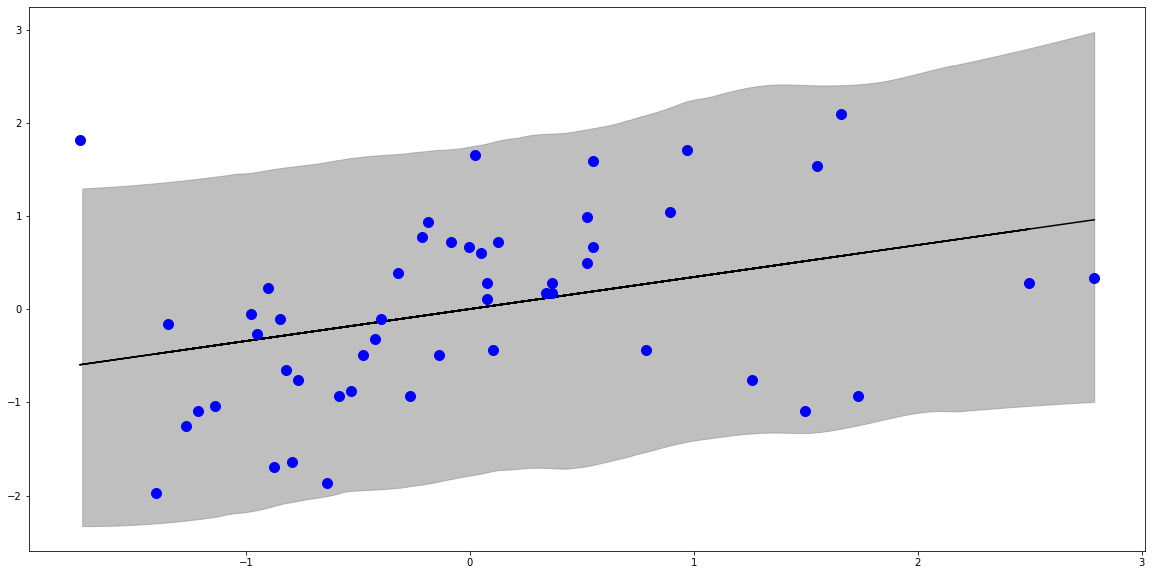

In [49]:
fig, ax = plt.subplots(figsize=(20,10))
az.plot_hdi(data["Marriage_std"], posteriorpredictive_marrage_rate["divorce_rate_std"], credible_interval=0.94, color='gray', ax=ax)
plt.plot(data["Marriage_std"], marriagerate_trace["a"].mean() +  marriagerate_trace["bM"].mean() * (data["Marriage_std"]),color="black")
plt.plot(data["Marriage_std"],data["Divorce_std"], 'b.', markersize=20)

As you can see in the figure, this relationship isn’t as strong as the previous one.
But merely comparing parameter means between different bivariate regressions is no
way to decide which predictor is better.<b> Both of these predictors could provide independent
value, or they could be redundant, or one could eliminate the value of the other.</b>


To make sense of this, we’re going to have to think causally. And then, only after we’ve
done some thinking, a bigger regression model that includes both age at marriage and marriage
rate will help us.


In [58]:
marriagerate_trace["bM"].mean()


0.3439114309747215

<h1>Multiple regression </h1>

Reasons given for
multiple regression models include:

(1) Statistical “control” for confounds. A confound is something that misleads us about
a causal influence—there will be a more precise definition in the next chapter. The
spurious waffles and divorce correlation is one possible type of confound, where the
confound (southernness) makes a variable with no real importance (Waffle House
density) appear to be important. But confounds are diverse. They can hide real
important variables just as easily as they can produce false ones.

(2) Multiple causation. A phenomenon may arise from multiple causes. Measurement
of each cause is useful, so when we can use the same data to estimate more than onetype of influence, we should. Furthermore, when causation is multiple, one cause
can hide another.


(3) Interactions. The importance of one variable may depend upon another. For example,
plants benefit from both light and water. But in the absence of either, the
other is no benefit at all. Such interactions occur very often. Effective inference
about one variable will often depend upon consideration of others.


in our case  merely comparing parameter means between different bivariate regressions is no
way to decide which predictor is better. Both of these predictors could provide independent
value, or they could be redundant, or one could eliminate the value of the other.

To make sense of this, we’re going to have to think causally. And then, only after we’ve
done some thinking, a bigger regression model that includes both age at marriage and marriage
rate will help us.




<h2>Think before you regress</h2>.  
<p>There are three observed variables in play: divorce rate
(D), marriage rate (M), and the median age at marriage (A) in each State. </p><p>The pattern we
see in the previous two models and illustrated in Figure   is symptomatic of a situation in
    which only one of the predictor variables, <b>A</b> in this case, has a causal impact on the outcome,
D, even though both predictor variables are strongly associated with the outcome.</p>

<p>
To understand this better, it is helpful to introduce a particular type of causal graph
known as a DAG, short for directed acyclic graph. Graph means it is nodes and connections.
Directed means the connections have arrows that indicate directions of causal influence.
And acyclic means that causes do not eventually flow back on themselves. A DAG
is a way of describing qualitative causal relationships among variables. It isn’t as detailed as
a full model description, but it contains information that a purely statistical model does not.
Unlike a statistical model, a DAG, if it is correct, will tell you the consequences of intervening
to change a variable.</p>



Few interesting assumptions (or rather deductions) -

    a) Meadian Age at marriage has a direct impact on Divorce rate as people may grow incompatible with the parter

    b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

    c) Finally, Meadian Age has an impact on Marriage Rate because there are more young people means that more marriages

Another way to represent above is :

A -> D

M -> D

A -> M
Here is a DAG for our divorce rate example:

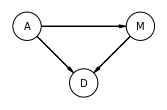

In [50]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()



Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)







MEDIATION - Let's say that A did not directly influence D; rather it did it via M. This type of relationship is called Mediation

Is  there indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a spurious correlation between marriage rate and divorce rate ?

To infer the strength of this models we need more than one statistical model.

Model <it>medianagevsdivorce </it>  -, the regression of D on A tells us only that the "total influence"  of Age with marriage is strongly negative with divorce rate.
: What is meant by total is that we need to account for every path from A to D.


How can we show that the inderect path  (A->M->D) does almost no work?

We know from the marriagerate model mariage rate is positivley associated with divorce rate. But it is not enough to assume that the path M->d is positive. It could be that the association of M and D arises  entirely from A's influence on both M and D like below:


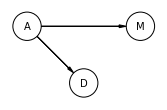

In [51]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

This DAG is also consistent with the posterior distributions of models >medianagevsdivorce and marriagerate. So
which is it? Is there a direct effect of marriage rate, or rather is age at marriage just driving
both, creating a spurious correlation between marriage rate and divorce rate?

<h2>Testable implications.</h2> How do we use data to compare multiple, plausible causal
models? The first thing to consider are the testable implications of each model. 


Any DAG may imply that some variables are independent of others under certain conditions.
These are the model’s testable implications, it’s conditional independencies. 
<p>Conditional
independencies come in two forms.</p>

i) First, they are statements of which variables
should be associated with one another (or not) in the data. 

ii) Second, they are statements of
which variables become dis-associated when we condition on some other set of variables.

In more formal notation, the implication that some variable Y is not associated with some
variable X, after conditioning on some other variable Z is written: Y ⊥⊥ X|Z. So let’s consider this
in the context of the divorce example.
<p>
For the DAG on the left above, the one with three arrows, first note that every pair of
variables is correlated. This is because there is a causal arrow between every pair. These
arrows create correlations. So before we condition on anything, everything is associated
with everything else. This is already a testable implication. We could write it:
D⊥̸⊥ A,D⊥̸⊥ M, A⊥̸⊥ M</p>
That⊥̸⊥ thing means “not independent of.” If we now look in the data and find that any
pair of variables are not associated, then something is wrong with the DAG (assuming the
data are correct). 

In these data, all three pairs are in fact strongly associated. Check for
yourself. You can use  correlations. Correlations are very simple
and sometimes terrible measures of association—mamy different patterns of association with
different implications can produce the same correlation. But they do honest work in this case.


In [52]:
data.corr()

,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Divorce_std,Marriage_std,MedianAgeMarriage_std
Population,1.000000,0.197879,-0.243737,-0.639781,-0.260001,-0.669410,0.219975,0.156170,0.080311,0.420612,0.164525,-0.260001,-0.243737,0.197879
MedianAgeMarriage,0.197879,1.000000,-0.721096,-0.208837,-0.597239,-0.093827,-0.118261,-0.248057,-0.129206,0.327320,-0.099376,-0.597239,-0.721096,1.000000
Marriage,-0.243737,-0.721096,1.000000,0.544223,0.373731,0.278377,0.027122,0.081795,0.035134,-0.387186,0.003025,0.373731,1.000000,-0.721096
Marriage SE,-0.639781,-0.208837,0.544223,1.000000,0.151670,0.892883,-0.277148,-0.250765,-0.224769,-0.550039,-0.224198,0.151670,0.544223,-0.208837
Divorce,-0.260001,-0.597239,0.373731,0.151670,1.000000,0.256225,0.254475,0.345176,0.277089,-0.200044,0.206401,1.000000,0.373731,-0.597239
Divorce SE,-0.669410,-0.093827,0.278377,0.892883,0.256225,1.000000,-0.308487,-0.265092,-0.263072,-0.519995,-0.270978,0.256225,0.278377,-0.093827
WaffleHouses,0.219975,-0.118261,0.027122,-0.277148,0.254475,-0.308487,1.000000,0.686150,0.746961,0.180159,0.735561,0.254475,0.027122,-0.118261
South,0.156170,-0.248057,0.081795,-0.250765,0.345176,-0.265092,0.686150,1.000000,0.831994,0.151969,0.835512,0.345176,0.081795,-0.248057
Slaves1860,0.080311,-0.129206,0.035134,-0.224769,0.277089,-0.263072,0.746961,0.831994,1.000000,0.198954,0.895603,0.277089,0.035134,-0.129206
Population1860,0.420612,0.327320,-0.387186,-0.550039,-0.200044,-0.519995,0.180159,0.151969,0.198954,1.000000,0.109222,-0.200044,-0.387186,0.327320


Let's consider  the second dag .In this DAG, it is still true that all three variable are associated with one another. A is associated with D and M because it influences them both.

And D and M are associated with
one another, because A influences them both. They share a cause, and this leads them to be
correlated with one another through that cause. 

But suppose we condition on A. 
All of the
information in M that is relevant to predicting D is in A. So once we’ve conditioned on A,
M tells us nothing more about D. 

So in the second DAG, a testable implication is that D is
independent of M, conditional on A. 
In other words, D ⊥⊥ M|A. The same thing does not
happen with the first DAG. Conditioning on A does not make D independent of M, because
M really influences D all by itself in this model.


You can also see this by the follwing snippet:



In [53]:


dag5_2.get_all_independence_relationships()



[('M', 'D', {'A'})]

So in the second DAG, a testable implication is that D is
independent of M, conditional on A. In other words, D ⊥⊥ M|A.

Let’s try to summarize. 
<p>The testable implications of the first DAG are that all pairs of variables
should be associated, whatever we condition on. </p>
<p>The testable implications of the second
DAG are that all pairs of variables should be associated, before conditioning on anything, but
that D and M should be independent after conditioning on A. So the only implication that
differs between these DAGs is the last one: D ⊥⊥ M|A.</p>
<p>
To test this implication, we need a statistical model that conditions on A, so we can see
whether that renders D independent of M. And that is what multiple regression helps with.
It can address a useful descriptive question:</p>

Is there any additional value in knowing a variable, once I already know all of
the other predictor variables?


So for example once you fit a multiple regression to predict divorce using both marriage rate
and age at marriage, the model addresses the questions:


(1) After I already know marriage rate, what additional value is there in also knowing
age at marriage?


(2) After I already know age at marriage, what additional value is there in also knowing
marriage rate?


The parameter estimates corresponding to each predictor are the (often opaque) answers to
these questions. 

The questions above are descriptive, and the answers are also descriptive.

It is only the derivation of the testable implications above that give these descriptive results a
causal meaning.

Multiple regression model 


Di ∼ Normal(μi, σ) [probability of data]

μi = α + β<sub>M</sub> M<sub>i</sub> + β<sub>A</sub>A<sub>i</sub>  [linear model]

α ∼ Normal(0, 0.2) [prior for α]

β<sub>M</sub> ∼ Normal(0, 0.5) [prior for βM]

β<sub>A</sub>∼ Normal(0, 0.5) [prior for βA]

σ ∼ Exponential(1) [prior for σ

So what does it mean to assume μi = α + β<sub>M</sub> M<sub>i</sub> + β<sub>A</sub>A<sub>i</sub>? It means that the expected
outcome for any State with marriage rate Mi and median age at marriage Ai is the sum of three
independent terms. The first term is a constant, α. Every State gets this. The second term is
the product of the marriage rate, Mi, and the coefficient, βM, that measures the association
between marriage rate and divorce rate. The third term is similar, but for the association
with median age at marriage instead.
If you are like most people, this is still pretty mysterious. So it might help to read the +
symbols as “or” and then say: A State’s divorce rate can be a function of its marriage rate or its
median age at marriage.

In [54]:
with pm.Model() as multregdiv:
    # M->D<-A 
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"] + bA * data["MedianAgeMarriage_std"]
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    multregdiv_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, bA, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 223.24draws/s]


In [55]:
az.summary(multregdiv_trace, var_names=["a", "bM", "bA", "sigma"])

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.099,-0.188,0.177,0.003,0.003,826.0,626.0,824.0,656.0,1.01
bM,-0.048,0.156,-0.341,0.235,0.007,0.005,571.0,571.0,568.0,644.0,1.00
bA,-0.592,0.152,-0.854,-0.287,0.007,0.005,533.0,524.0,532.0,520.0,1.00
sigma,0.830,0.087,0.664,0.989,0.004,0.003,600.0,590.0,618.0,747.0,1.00


The posterior mean for marriage rate, bM,   is now close to zero, with plenty of probability
of both sides of zero. The posterior mean for age at marriage, bA, is essentially unchanged. Let's draw them

In [29]:
mediangevsd_tarce

<MultiTrace: 2 chains, 500 iterations, 5 variables>

In [56]:
az.plot_forest(
    ["multregdiv_trace", "marriagerate_trace","mediangevsd_tarce"],
    model_names=["multregdiv", "marriagerate","medianagevsdivorce"],
    var_names=["bA", "bM"],
    combined=True,
);


FileNotFoundError: [Errno 2] No such file or directory: b'mediangevsd_tarce'

Notice how bA doesn’t move, only grows a bit more uncertain, while bM is only
associated with divorce when age at marriage is missing from the model. You can interpret
these distributions as saying:

Once we know median age at marriage for a State, there is little or no additional
predictive power in also knowing the rate of marriage in that State.

Since the first DAG did not imply this result, it is out.
Note that this does not mean that there is no value in knowing marriage rate. Consistent
with the earlier DAG, if you didn’t have access to age-at-marriage data, then you’d definitely
find value in knowing the marriage rate. This implies there is no, or almost no, direct causal
path from marriage rate to divorce rate. The association between marriage rate and divorce
rate is spurious, caused by the influence of age of marriage on both marriage rate and divorce
rate. 

<h1>HW</h1>: investigate the relationship between age at marriage, A, and
marriage rate, M, to complete the picture.

<h1>Plotting multivariate posteriors</h1>
<p>
Visualizing the posterior distribution
in simple bivariate regressions, like those in the previous examples, is easy. There’s only one
predictor variable, so a single scatterplot can convey a lot of information.</p>


<p> With multivariate regression, you’ll need more plots:
    None of these techniques is suitable for all jobs, and most do not generalize beyond
linear regression.</p>

(1) Predictor residual plots. These plots show the outcome against residual predictor
values. They are useful for understanding the statistical model, but not much else.

(2) Posterior prediction plots. These show model-based predictions against raw data,
or otherwise display the error in prediction. They are tools for checking fit and
assessing predictions. They are not causal tools.

(3) Counterfactual plots. These show the implied predictions for imaginary experiments.
These plots allow you to explore the causal implications of manipulating
one or more variables.



<h1> Predictor residual plots.</h1>
A predictor variable residual is the average prediction error when we use all of the other predictor variables to model a predictor of interest. 

The benefit of computing these things is that, once plotted against the outcome, we have a bivariate
regression of sorts that has already “controlled” for all of the other predictor variables.
It just leaves in the variation that is not expected by the model of the mean, μ, as a function of the
other predictors.




In our multivariate model of divorce rate, we have two predictors:

(1) marriage rate (M)
and 
(2) median age at marriage (A). 

To compute predictor residuals for either, we just use
the other predictor to model it. So for <b>marriage rate </b> we are going to use age rate to model it, this is the model we need:

M<sub>i</sub> ∼ Normal(μ<sub>i</sub>, σ)

μ<sub>i</sub> = α + β A<sub>i<sub>
    
α ∼ Normal(0, 0.2)
    
β ∼ Normal(0, 0.5)
    
σ ∼ Exponential(1)
    
    

In [31]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"])

    marriage_std = pm.Normal(
        "divorce_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()
    

   
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAM, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 268.24draws/s]


In [32]:
#A predictor variable residual is the average prediction error 
#when we use all of the other predictor variables to model a predictor of interest. 
mu_m_5_4_mean = m_5_4_trace["mu"].mean(axis=0) #our prediction of mu using age which becomes the mu of 
residuals = data["Marriage_std"] - mu_m_5_4_mean # the normal distribution of Marriage rate

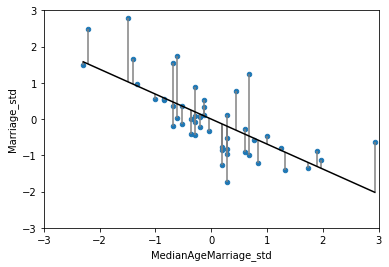

In [33]:
idx = np.argsort(data.MedianAgeMarriage_std)
data.plot('MedianAgeMarriage_std', 'Marriage_std', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(data.MedianAgeMarriage_std[idx], mu_m_5_4_mean[idx], 'k')
plt.vlines(data.MedianAgeMarriage_std, mu_m_5_4_mean, mu_m_5_4_mean+ residuals, colors='grey');

<h2> Posterior prediction plots.</h2> 


(1) Did the model correctly approximate the posterior distribution? 
Errors can be more easily diagnosed by comparing implied predictions to the raw data. 
Some caution is required, because not all
models try to exactly match the sample. But even then, you’ll know what to expect
from a successful approximation. 


(2) How does the model fail? All models are useful fictions, so they always fail in some
way. Sometimes, the model fits correctly but is still so poor for our purposes that
it must be discarded. More often, a model predicts well in some respects, but not
in others. By inspecting the individual cases where the model makes poor predictions,
you might get an idea of how to improve the model. The difficulty is that this
process is essentially creative and relies upon the analysts domain expertise. It also risks chasing noise.


In [34]:
with multregdiv:
     m_5_3_ppc = pm.sample_posterior_predictive(
    multregdiv_trace, var_names=["mu", "divorce_rate_std"], samples=1000
    )

100%|██████████| 1000/1000 [00:02<00:00, 444.30it/s]


For multivariate models, there are many different ways to display these simulations. The
simplest is to just plot predictions against observed. 

In [35]:
mu_mean = m_5_3_ppc["mu"].mean(axis=0)
mu_hpd = az.hdi(m_5_3_ppc["mu"], 0.89)

D_sim = m_5_3_ppc["divorce_rate_std"].mean(axis=0)
D_PI = az.hdi(m_5_3_ppc["divorce_rate_std"], 0.89)

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


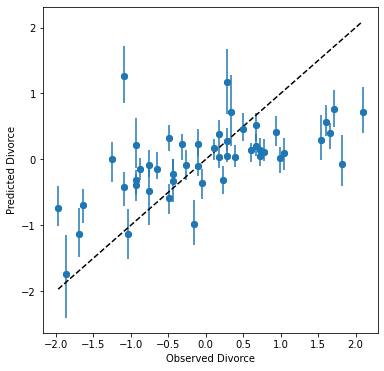

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    m_5_3_ppc["divorce_rate_std"].mean(0),
    yerr=np.abs(m_5_3_ppc["divorce_rate_std"].mean(0) - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");
#plt.savefig('out1.png')

It’s easy to see from this arrangement of the simulations
that the model under-predicts for States with very high divorce rates while it overpredicts
for States with very low divorce rates.That’s normal. This is what regression does—it
is skeptical of extreme values, so it expects regression towards the mean. But beyond this general
regression to the mean, some States are very frustrating to the model, lying very far from
the diagonal. I’ve labeled some points like this, including Idaho (ID) and Utah (UT), both of which have much lower divorce rates than the model expects them to have.

What is unusual about Idaho and Utah? Both of these States have large proportions of
members of the Church of Jesus Christ of Latter-day Saints. Members of this church have
low rates of divorce, wherever they live. This suggests that having a finer view on the demographic
composition of each State, beyond just median age at marriage, would help a lot to
refine our understanding.

<h1>Counterfactual plots.</h1>
A second sort of inferential plot displays the implied predictions
of the model.  These plots are called counterfactual  , because they can be produced
for any values of the predictor variables you like, even unobserved or impossible combinations
like very high median age of marriage and very high marriage rate. 
There are no States
with this combination, but in a counterfactual plot, you can ask the model for a prediction
for such a State. 
This means you have take care not to plot nonsense. But used with clarity of
purpose, counterfactual plots help you understand the model and generate predictions for
imaginary interventions.
The simplest use of a counterfactual plot is to see how the predictions change as you
change only one predictor at a time.
This means holding the values of all predictors constant,
except for a single predictor of interest. A tension with such plots, however, is that they ignore
the assumed causal structure. In the small world of the model, it is possible to change median
age of marriage without also changing the marriage rate.
But is this also possible in the large
world of reality? Probably not. Suppose for example that you pay young couples to postpone
marriage until they are 35 years old. Surely this will also decrease the number of couples who
ever get married—some people will die before turning 35, among other reasons—decreasing
the overall marriage rate. An extraordinary and evil degree of control over people would be
necessary to really hold marriage rate constant while forcing everyone to marry at a later age.



So let’s see how to generate plots of model predictions that take the causal structure into
account. The basic recipe is:


(1) Pick a variable to manipulate, the intervention variable.


(2) Define the range of values to set the intervention variable to.


(3) For each value of the intervention variable, and for each sample in posterior, use
the causal model to simulate the values of other variables, including the outcome.
In the end, you end up with a posterior distribution of counterfactual outcomes that you can
plot and summarize in various ways, depending upon your goal.


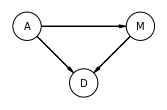

In [59]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()


    
To simulate from this, we need more than the DAG. We also need a set of functions that tell
us how each variable is generated. For simplicity, we’ll use the  distributions for each
variable from model multregdiv. But model multregdiv ignored the assumption that <b>A</b> influences
<b>M</b>. We didn’t need that to estimate A → D. But we do need it to predict the consequences
of manipulating A, because some of the effect of A acts through M.
<b>To estimate the influence of A on M, all we need is to regress A on M</b>, there are no
other variables in the DAG creating an association between A and M.

In [60]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:16<00:00, 119.41draws/s]


In [61]:
m5_3_A_trace.varnames

['sigma_log__',
 'bA',
 'bM',
 'a',
 'sigma_m_log__',
 'bAM',
 'aM',
 'sigma',
 'mu',
 'sigma_m',
 'mu_m']

In [62]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

100%|██████████| 1000/1000 [00:07<00:00, 129.32it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


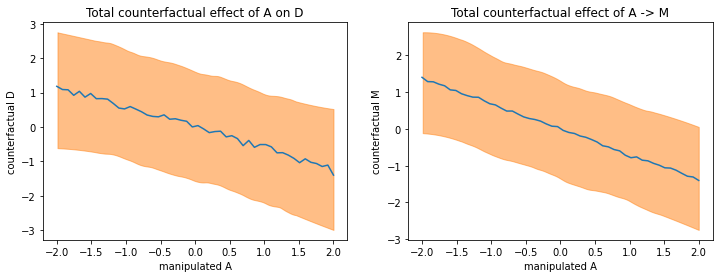

In [63]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(A_seq, m5_3_M_marriage["divorce"].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage["divorce"], ax=ax[0])
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


ax[1].plot(A_seq, m5_3_M_marriage["marriage"].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage["marriage"], ax=ax[1])
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

In [64]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

100%|██████████| 1000/1000 [00:08<00:00, 113.33it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


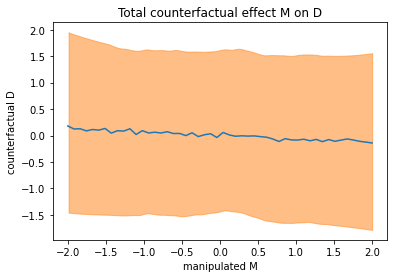

In [65]:
fig, ax = plt.subplots()

ax.plot(marriage_counter_factual_x, m5_3_M_ppc["divorce"].mean(0))
az.plot_hpd(marriage_counter_factual_x, m5_3_M_ppc["divorce"], ax=ax)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

The counterfactual effect of manipulating
marriage rate M on divorce rate D.
Since M → D was estimated to be very small,
there is almost no trend here. By manipulating
M, we break the influence of A on M, and
this removes the association between M and
D.

<h1>Masked relationship</h1>


The divorce rate example demonstrates that multiple predictor variables are useful for
knocking out spurious association.

A second reason to use more than one predictor variable
is to measure the direct influences of multiple factors on an outcome, when none of those
influences is apparent from bivariate relationships.

This kind of problem tends to arise when
there are two predictor variables that are correlated with one another.
However, one of these
is positively correlated with the outcome and the other is negatively correlated with it.

You’ll consider this kind of problem in a new data context, information about the composition
of milk across primate species, as well as some facts about those species, like body
mass and brain size.

Milk is a huge investment, being much more expensive than gestation.
Such an expensive resource is likely adjusted in subtle ways, depending upon the physiological
and development details of each mammal species.

A popular hypothesis has it that primates with larger brains produce more energetic
milk, so that brains can
grow quickly. Answering questions of this sort consumes a lot of
effort in evolutionary biology, because there are many subtle statistical issues that arise when
comparing species.
We’ll start simple, evantaully  we’ll include some more of
these subtle issues. The variables we’ll consider for now are:
kcal.per.g : Kilocalories of energy per gram of milk.
mass : Average female body mass, in kilograms.
neocortex.perc : The percent of total brain mass that is neocortex mass.

The question here is to what extent energy content of milk, measured here by kilocalories, is
related to the percent of the brain mass that is neocortex.
Neocortex is the gray, outer part
of the brain that is particularly elaborated in mammals and especially primates. 
We’ll end
up needing female body mass as well, to see the masking that hides the relationships among
the variables. Let’s standardize these three variables. As in previous examples, standardizing
helps us both get a reliable approximation of the posterior as well as build reasonable priors

In [66]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [85]:
d.head(100)

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,NaN,-0.510160,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,NaN,-0.493204,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,NaN,-0.529134,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,NaN,-0.506123,3
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588,1
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744,1
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204,1
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1.662163,NaN,-0.565871,1
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082,1


In [67]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

The first model to consider is the simple bivariate regression between kilocalories and
neocortex percent. In mathematical form:


K<sub>i</sub> ∼ Normal(μ<sub>i</sub>, σ)

μi = α + β<sub>N</sub>N<sub>i</sub>

where K is standardized kilocalories and N is standardized neocortex percent. We still need
to consider the priors. But first let’s just try to run this  model with some vague
priors, because there is another key modeling issue to address first.

In [68]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"])

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences:   0%|          | 0/2000 [00:07<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
K   NaN


ParallelSamplingError: Bad initial energy

In [ ]:
d["neocortex.perc"]

In [69]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

In [71]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 182.40draws/s]


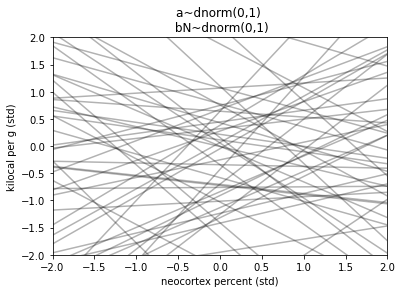

In [72]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5_draft_prior_predictive["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

I’ve shown a range of 2 standard deviations
for both variables. So that is most of the outcome space. These lines are crazy. As
in previous examples, we can do better by both tightening the α prior so that it sticks closer
to zero. 
With two standardized variables, when predictor is zero, the expected value of the
outcome should also be zero.
And the slope βN needs to be a bit tighter as well, so that it
doesn’t regularly produce impossibly strong relationships. Here’s an attempt:

In [73]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:13<00:00, 144.70draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


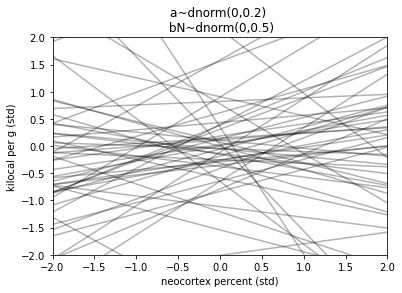

In [74]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5_prior_predictive = pm.sample_prior_predictive()
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5_prior_predictive["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,0.2) \n bN~dnorm(0,0.5)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

<h1> HomeWork</h1>
plot the posterior distrubution for the above model.

In [ ]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

From this summary, you can possibly see that this is neither a strong nor very precise association.
The standard deviation is almost twice the posterior mean. But as always, it’s much
easier to see this if we draw a picture. e can plot the predicted mean and compatibility interval for the mean to see
this more easily:

100%|██████████| 4000/4000 [00:03<00:00, 1145.79it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


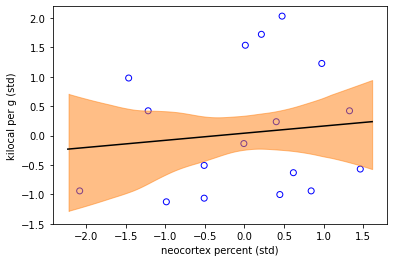

In [75]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(
        m5_5_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_5_posterior_predictive["mu"], ax=ax)
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");


In [76]:
az.summary(m5_5_posterior_predictive)

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/base.py:167: UserWarning: More chains (4000) than draws (30). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,0.004,0.35,-0.717,0.661,0.004,0.003,6156.0,6156.0,6036.0,10708.0,2.35


The posterior mean line is weakly positive,
but it is highly imprecise. A lot of mildly positive and negative slopes are plausible, given this
model and these data.


Now consider another predictor variable, adult female body mass, mass in the data
frame. 
Now we construct a similar model, but consider the bivariate relationship between kilocalories
and body mass:

In [77]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:11<00:00, 176.90draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.301,0.242,-0.763,0.127,0.008,0.005,1035.0,1035.0,1041.0,842.0,1.0
a,0.048,0.164,-0.252,0.363,0.005,0.006,1286.0,413.0,1284.0,531.0,1.0
sigma,1.055,0.209,0.720,1.410,0.007,0.005,996.0,925.0,1076.0,704.0,1.0


100%|██████████| 4000/4000 [00:04<00:00, 844.41it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


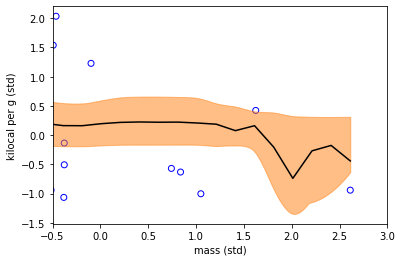

In [78]:
xseq = np.linspace(dcc["M"].min() , dcc["M"].max() , 17)

shared_N.set_value(xseq)

with m5_6:
    m5_6_posterior_predictive = pm.sample_posterior_predictive(
         m5_6_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6_posterior_predictive["mu"], ax=ax)
ax.set_xlim(-0.5, 3)
ax.set_xlabel("mass (std)")
ax.set_ylabel("kilocal per g (std)");

In [79]:
dcc['log_mass'] = np.log(dcc['mass'])
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_6p:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6p_trace = pm.sample()

m5_6p_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6p_trace, var_names=["bM", "a", "sigma"])

<ipython-input-79-e82c27ce886e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc['log_mass'] = np.log(dcc['mass'])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 182.67draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.121,0.120,-0.372,0.081,0.004,0.004,737.0,560.0,732.0,579.0,1.0
a,0.113,0.174,-0.200,0.426,0.007,0.005,699.0,579.0,698.0,663.0,1.0
sigma,1.087,0.201,0.737,1.471,0.007,0.005,742.0,740.0,746.0,584.0,1.0


100%|██████████| 4000/4000 [00:04<00:00, 937.46it/s] 
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


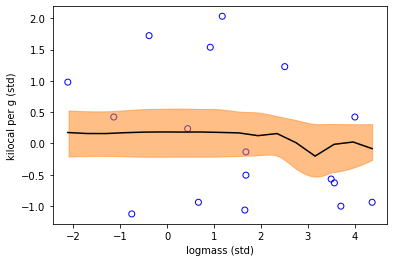

In [80]:
xseq = np.linspace(dcc["log_mass"].min() , dcc["log_mass"].max() , 17)

shared_N.set_value(xseq)

with m5_6:
    m5_6_posterior_predictive = pm.sample_posterior_predictive(
         m5_6_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6p_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["log_mass"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6p_posterior_predictive["mu"], ax=ax)
#ax.set_xlim(-0.5, 3)
ax.set_xlabel("logmass (std)")
ax.set_ylabel("kilocal per g (std)");

Now let’s see what happens when we add both predictor variables at the same time to the
regression. This is the multivariate model, in math form:
Ki ∼ Normal(μi, σ)
μi = α + βNNi + βMMi
α ∼ Normal(0, 0.2)
βn ∼ Normal(0, 0.5)
βm ∼ Normal(0, 0.5)
σ ∼ Exponential(1)

In [81]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 24000/24000 [01:47<00:00, 224.27draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.197,0.184,-0.136,0.557,0.002,0.001,9457.0,9281.0,9449.0,11464.0,1.0
bN,0.408,0.280,-0.136,0.921,0.003,0.002,9619.0,9619.0,9667.0,11904.0,1.0
bM,-0.233,0.135,-0.477,0.032,0.001,0.001,8541.0,8541.0,8609.0,10733.0,1.0
sigma,0.984,0.202,0.650,1.364,0.002,0.001,9143.0,9143.0,9213.0,10781.0,1.0


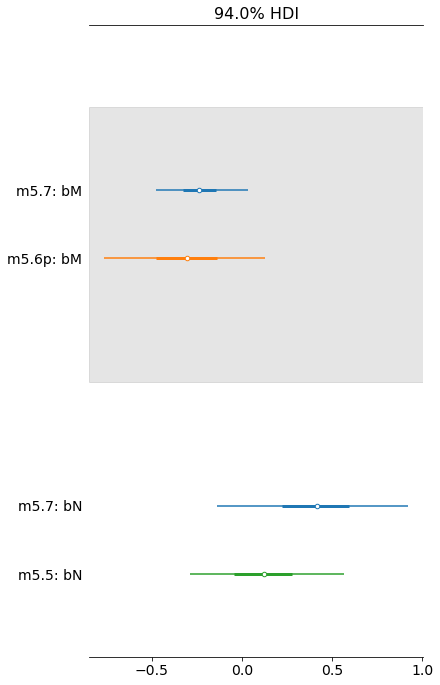

In [82]:
az.plot_forest(
    [m5_7_data,m5_6p_data, m5_5_data],
    model_names=["m5.7","m5.6p", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);


The posterior mean for the association of neocortex percent has increased fivefold, and its
89% interval is now entirely above zero. The posterior mean for log body mass has increased
2.5 times in magnitude.

This is a context in which there are two variables
correlated with the outcome, but one is positively correlated with it and the other is negatively
correlated with it. 

In addition, both of the explanatory variables are positively correlated with
one another. 

 As a result, they tend to cancel one another out.
 
 
This is another case in which multiple regression automatically finds the most revealing
cases and uses them to produce inferences. 

What the regression model does is ask if species
that have high neocortex percent for their body mass have higher milk energy. Likewise, the
model asks if species with high body mass for their neocortex percent have higher milk energy.


Bigger species, like apes, have milk with less energy. But species with more neocortex tend
to have richer milk. 
The fact that these two variables, body size and neocortex, are correlated
across species makes it hard to see these relationships, unless we account for both.




/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 4000/4000 [00:05<00:00, 678.71it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


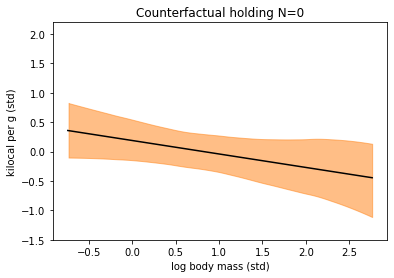

In [83]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(
        m5_7_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
az.plot_hpd(xseq, m5_7_posterior_predictive["mu"], ax=ax)

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

<h1> Categorical Values </h1>

A common question for statistical methods is to what extent an outcome changes as a
result of presence or absence of a category. A category here means discrete and unordered.
For example, consider the different species in the milk energy data again. Some of them are
apes, while others are New World monkeys. We might want to ask how predictions should
vary when the species is an ape instead of a monkey. Taxonomic group is a categorical
variable, because no species can be half-ape and half-monkey (discreteness), and there
is no sense in which one is larger or smaller than the other (unordered). Other common
examples of categorical variables include:
• Sex: male, female
• Developmental status: infant, juvenile, adult
• Geographic region: Africa, Europe, Melanesia


In [ ]:
#d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
#d.head()

In [86]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

In [87]:
d.head(100)


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,NaN,-0.510160,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,NaN,-0.493204,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,NaN,-0.529134,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,NaN,-0.506123,3
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588,1
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744,1
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204,1
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1.662163,NaN,-0.565871,1
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082,1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:23<00:00, 85.88draws/s] 
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


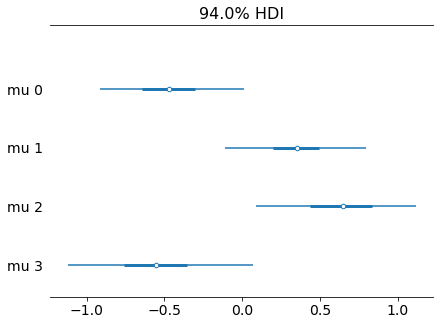

In [88]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=d["clade_id"].max() + 1)
    K = pm.Normal("K", mu[d["clade_id"]], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);